# Overview - EARLIER SAVE FOR CROSS REFERENCE. DO NOT EDIT OR RUN.

This notebook demonstrates getting Planck simulations, determining the power spectra thereof, then getting a condensed representation of the covariance matrix using PCA. It draws 100 sample power spectra based on those.

In [1]:
from pathlib import Path

import numpy as np
import healpy as hp

import matplotlib.pyplot as plt
import matplotlib.transforms as transforms

from tqdm import tqdm  # For progress bars

from handle_data import get_map_dtype, get_planck_obs_data, get_planck_noise_data

In [2]:
import logging

In [3]:
logger = logging.getLogger("handle_data")
logger.setLevel(logging.DEBUG)

In [4]:
DATA_ROOT = "/data/jim/CMB_Data/"
ASSETS_DIRECTORY = f"{DATA_ROOT}/Assets/Planck/"
PLANCK_NOISE_DIR = f"{DATA_ROOT}/Planck_Noise/"

DETECTOR = 100
N_PLANCK_SIMS = 100

NSIDE = 2048

In [5]:
def get_lmax_for_nside(nside):
    """Helper function: Max ell for a given nside; to be considered a parameter"""
    return 3 * nside - 1

# Setup

In [6]:
def plot_ps(ps,
            title=None, 
            x_low=1,
            x_high=1e4,
            y_low=1e-4,
            y_high=1e2,
            white_noise_expected=None):
    y_label="$N_{\\ell}(\\mu K^2)$"
    x_label="$\\ell$"
    plt.figure()
    plt.plot(ps)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xscale('log')
    plt.yscale('log')
    if white_noise_expected is not None:
        plt.axhline(y=white_noise_expected, color='black', linestyle='--')
        plt.text(y=white_noise_expected, x=x_high, s="$\\sigma_{\\ell}=" + f"{white_noise_expected:.1e}$", 
                 color='black',
                 horizontalalignment='right', verticalalignment='bottom')
    plt.xlim([x_low, x_high])
    plt.ylim([y_low, y_high])
    plt.title(title)
    plt.show()

In [7]:
def plot_many_ps(ps_s,
            title=None, 
            x_low=0.7,
            x_high=1e4,
            y_low=1e-4,
            y_high=1e2,
            styles=None,
            labels=None,
            white_noise_expected=None,
            has_planck=False,
            legend=True):
    y_label="$N_{\\ell}(\\mu K^2)$"
    x_label="$\\ell$"
    plt.figure()
    ells = np.arange(len(ps_s[0])).astype(float)
    if x_low < 1:
        ells[0] = x_low
    for i, ps in enumerate(ps_s):
        style=None
        linewidth=None
        color=None
        alpha=0.1
        if styles is None:
            pass
        elif styles[i] != "-":
            style = styles[i]
            linewidth = 2
        else:
            style = styles[i]
            linewidth = 1
        if has_planck and i == 0:
            color='black'
            linewidth=3
            alpha=1
        label = None if labels is None else labels[i]
        plt.plot(ells, ps, label=label, linestyle=style, color=color, linewidth=linewidth, alpha=alpha)
    if white_noise_expected is not None:
        plt.axhline(y=white_noise_expected, color='black', linestyle='--', linewidth=1)
        plt.text(y=white_noise_expected, x=x_high, s="$\\sigma_{\\ell}=" + f"{white_noise_expected:.1e}$", 
                 color='black',
                 horizontalalignment='right', verticalalignment='bottom')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim([x_low-0.00001, x_high])
    plt.ylim([y_low, y_high])
    plt.title(title)
    if legend:
        plt.legend()
    plt.show()

In [8]:
def plot_many_ps_hl_last(ps_s,
            title=None, 
            x_low=0.7,
            x_high=1e4,
            y_low=1e-4,
            y_high=1e2,
            styles=None,
            labels=None,
            white_noise_expected=None,
            legend=True):
    y_label="$N_{\\ell}(\\mu K^2)$"
    x_label="$\\ell$"
    plt.figure()
    ells = np.arange(len(ps_s[0])).astype(float)
    if x_low < 1:
        ells[0] = x_low
    for i, ps in enumerate(ps_s):
        style=None
        linewidth=None
        color='green'
        alpha=0.2
        if styles is None:
            pass
        elif styles[i] != "-":
            style = styles[i]
            linewidth = 2
        else:
            style = styles[i]
            linewidth = 1
        if i == len(ps_s) - 1:
            color='black'
            linewidth=3
            alpha=1
        label = None if labels is None else labels[i]
        plt.plot(ells, ps, label=label, linestyle=style, color=color, linewidth=linewidth, alpha=alpha)
    if white_noise_expected is not None:
        plt.axhline(y=white_noise_expected, color='black', linestyle='--', linewidth=1)
        plt.text(y=white_noise_expected, x=x_high, s="$\\sigma_{\\ell}=" + f"{white_noise_expected:.1e}$", 
                 color='black',
                 horizontalalignment='right', verticalalignment='bottom')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim([x_low-0.00001, x_high])
    plt.ylim([y_low, y_high])
    plt.title(title)
    if legend:
        plt.legend()
    plt.show()

In [9]:
def plot_many_ps_hl_last2(ps_s,
            title=None, 
            x_low=0.7,
            x_high=1e4,
            y_low=1e-4,
            y_high=1e2,
            styles=None,
            colors=None,
            alphas=None,
            labels=None,
            white_noise_expected=None,
            legend=True):
    y_label="$N_{\\ell}(\\mu K^2)$"
    x_label="$\\ell$"
    plt.figure()
    ells = np.arange(len(ps_s[0])).astype(float)
    if x_low < 1:
        ells[0] = x_low
    for i, ps in enumerate(ps_s):
        style=None
        linewidth=None
        color='green'
        alpha=0.05
        if styles is None:
            pass
        elif styles[i] != "-":
            style = styles[i]
            linewidth = 2
        else:
            style = styles[i]
            linewidth = 1
        if i == len(ps_s) - 1:
            color='black'
            linewidth=3
            alpha=1
        label = None if labels is None else labels[i]
        if colors is not None:
            color = colors[i]
        if alphas is not None:
            alpha = alphas[i]
        plt.plot(ells, ps, label=label, linestyle=style, color=color, linewidth=linewidth, alpha=alpha)
    if white_noise_expected is not None:
        plt.axhline(y=white_noise_expected, color='black', linestyle='--', linewidth=1)
        plt.text(y=white_noise_expected, x=x_high, s="$\\sigma_{\\ell}=" + f"{white_noise_expected:.1e}$", 
                 color='black',
                 horizontalalignment='right', verticalalignment='bottom')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim([x_low-0.00001, x_high])
    plt.ylim([y_low, y_high])
    plt.title(title)
    if legend:
        plt.legend()
    plt.show()

In [10]:
def make_map_hist(some_map, noise_level, title=None, legend=False):
    if isinstance(some_map, list):
        for i, one_map in enumerate(some_map):
            label = f"Map {i}" if legend else None
            plt.hist(one_map, bins=100, histtype='step', label=label)
    else:
        plt.hist(some_map, bins=100, histtype='step')
    plt.axvline(noise_level, color='black', linestyle='--', linewidth=1)
    plt.axvline(-noise_level, color='black', linestyle='--', linewidth=1)
    plt.text(x=-noise_level, y=175000, s=f"$-\\sigma$", color='black', 
            rotation=90,
            verticalalignment='center', horizontalalignment='right')
    offset = transforms.ScaledTranslation(2/72, 0, plt.gcf().dpi_scale_trans)
    plt.text(x=noise_level, y=175000, s=f"$+\\sigma$", color='black', 
            rotation=90,
            verticalalignment='center', horizontalalignment='left',
            transform=plt.gca().transData + offset)
    plt.xlabel("$\\mu K_{CMB}$")
    plt.ylabel("Pixel Count")
    if legend:
        plt.legend()
    plt.title(title)

# Planck Sims

In [11]:
lmax = get_lmax_for_nside(NSIDE)  # Defined above as 3*Nside-1

In [12]:
# Pre-download
for i in range(N_PLANCK_SIMS):
    src_map_fn = get_planck_noise_data(detector=DETECTOR, assets_directory=ASSETS_DIRECTORY, realization=i, progress=True)
print("All maps acquired!")

All maps acquired!


In [179]:
# Getting power spectra for 100 maps at 100 GHz takes ~50 minutes
src_cls = []
for i in tqdm(range(N_PLANCK_SIMS)):
    src_map_fn = get_planck_noise_data(detector=DETECTOR, assets_directory=ASSETS_DIRECTORY, realization=i, progress=True)
    t_src_map = hp.read_map(src_map_fn) * 1e6
    src_cls.append(hp.anafast(t_src_map, lmax=lmax))
del t_src_map

 38%|███▊      | 38/100 [19:01<31:20, 30.33s/it]

In [207]:
mean_cl = np.mean(src_cls, axis=0)

In [209]:
log_src_cls = np.log10(src_cls)
mean_log_src_cl = np.mean(log_src_cls, axis=0)

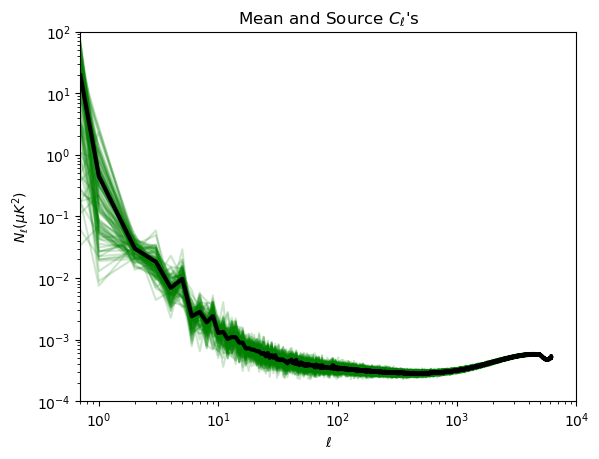

In [220]:
plot_many_ps_hl_last([*src_cls, mean_cl], title="Mean and Source $C_{\\ell}$'s", legend=False)

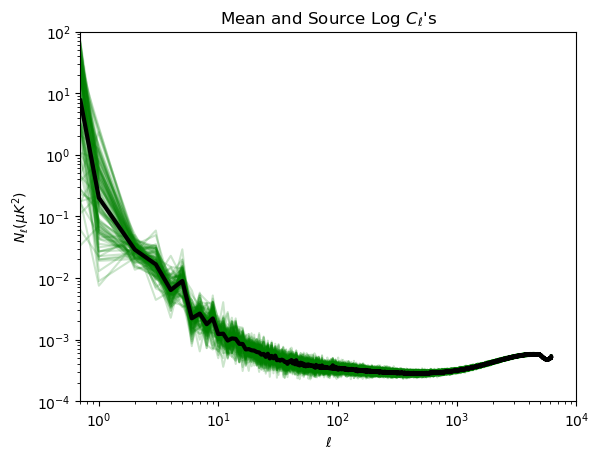

In [219]:
plot_many_ps_hl_last([*src_cls, 10**mean_log_src_cl], title="Mean and Source Log $C_{\\ell}$'s", legend=False)

In [181]:
cov_cl = np.cov(src_cls, rowvar=False)

In [182]:
cov_cl.shape

(6144, 6144)

In [183]:
new_cl = np.random.multivariate_normal(mean_cl, cov_cl, 1)
if np.any(new_cl < 0):
    print("Negative Cls detected!")
    print(new_cl[new_cl < 0])

In [184]:
mean_cl.shape, cov_cl.shape, new_cl[0].shape

((6144,), (6144, 6144), (6144,))

In [185]:
new_cl[0][0]

18.970244551027378

In [186]:
new_cl = np.random.normal(size=(1, len(mean_cl)))

In [187]:
len(src_cls)

100

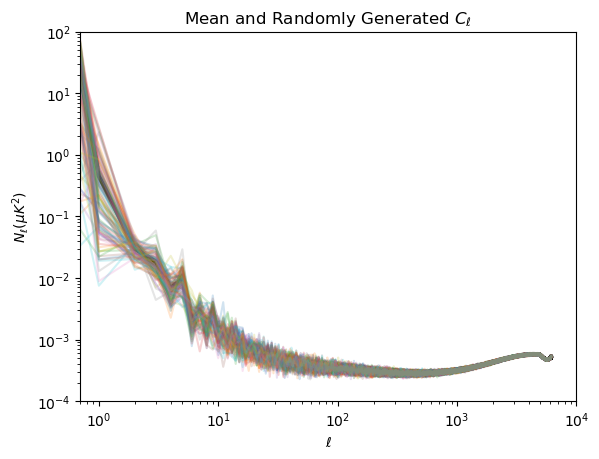

In [201]:
plot_many_ps([mean_cl, *src_cls], title="Mean and Randomly Generated $C_{\\ell}$", legend=False, has_planck=True)

In [189]:
np.savetxt(f"mean_cl_nside{NSIDE}_det{DETECTOR}2.txt", mean_cl)

In [190]:
check_cl = np.loadtxt(f"mean_cl_nside{NSIDE}_det{DETECTOR}.txt")
np.max(mean_cl - check_cl), np.min(mean_cl - check_cl)

(1.4916139855002157, -0.0001708297105253889)

In [191]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [258]:
log_src_cls = np.log10(src_cls)

pca = PCA().fit(log_src_cls)

cumulative_variance_log = np.cumsum(pca.explained_variance_ratio_)

threshold = 0.95
num_components = np.argmax(cumulative_variance_log >= threshold) + 1

mean_ps_pca = pca.mean_
components = pca.components_[:num_components]
explained_variance = pca.explained_variance_[:num_components]

# np.savez("all_ps_100GHz.npz", mean=mean_ps_pca, components=components, variance=explained_variance)

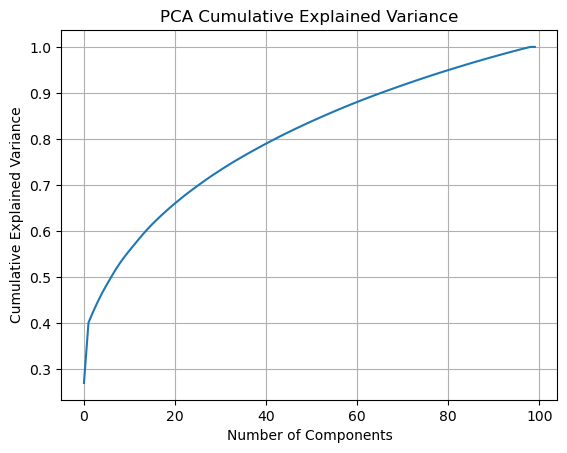

In [259]:
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

plt.plot(cumulative_variance)
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Cumulative Explained Variance")
plt.grid()
plt.show()

In [307]:
def get_n_components(n_cls, src_cls, threshold=0.95):
    _use_idcs = np.random.choice(range(100), n_cls, replace=False)
    _use_cls = np.array(src_cls)[_use_idcs]
    _pca = PCA().fit(_use_cls)
    _cumulative_variance = np.cumsum(_pca.explained_variance_ratio_)
    num_components = np.argmax(_cumulative_variance >= threshold) + 1
    return num_components, n_cls, threshold

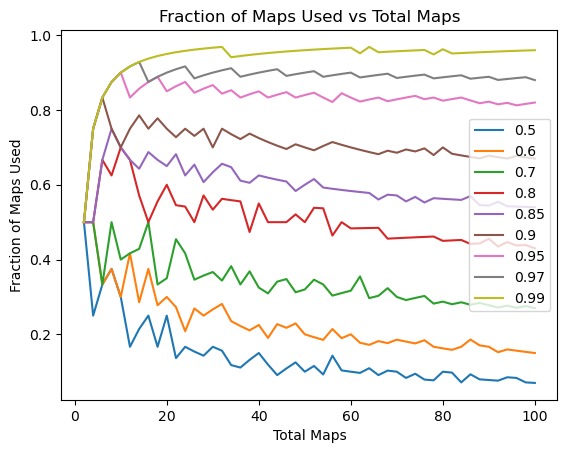

In [312]:
ratios = {}
for threshold in [0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 0.97, 0.99]:
    ratios[threshold] = []
    for _n_maps in [k*2 for k in range(1, 51)]:
        a, b, c = get_n_components(_n_maps, log_src_cls, threshold)
        ratios[threshold].append(a/b)

for threshold, v in ratios.items():
    map_count = [j*2 for j in range(1, 51)]
    plt.plot(map_count, v, label=f"{threshold}")
    plt.legend()
    plt.xlabel("Total Maps")
    plt.ylabel("Fraction of Maps Used")
    plt.title("Fraction of Maps Used vs Total Maps")

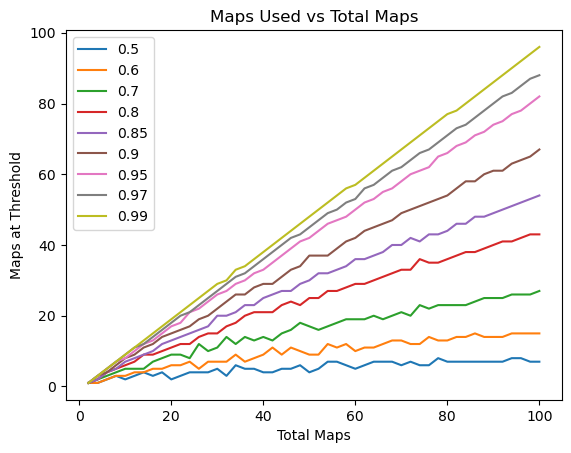

In [315]:
_n_maps = {}
for threshold in [0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 0.97, 0.99]:
    _n_maps[threshold] = []
    for total_maps in [k*2 for k in range(1, 51)]:
        a, b, c = get_n_components(total_maps, log_src_cls, threshold)
        _n_maps[threshold].append(a)

for threshold, v in _n_maps.items():
    map_count = [j*2 for j in range(1, 51)]
    plt.plot(map_count, v, label=f"{threshold}")
    plt.legend()
    plt.xlabel("Total Maps")
    plt.ylabel("Maps at Threshold")
    plt.title("Maps Used vs Total Maps")

In [ ]:
def look_at_curve(n_cls, src_cls):
    _pca = PCA().fit(src_cls[:n_cls])
    _cumulative_variance = np.cumsum(_pca.explained_variance_ratio_)

    plt.plot(_cumulative_variance)
    plt.xlabel("Number of Components")
    plt.ylabel("Cumulative Explained Variance")
    plt.title("PCA Cumulative Explained Variance")
    plt.grid()
    plt.show()

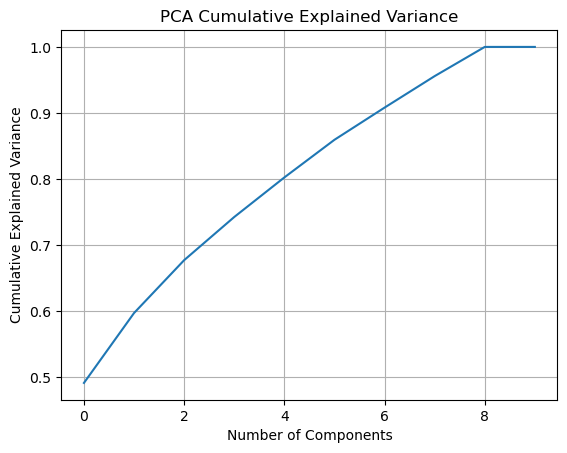

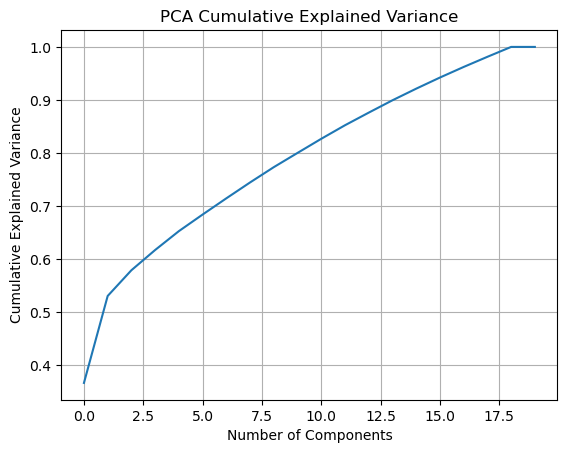

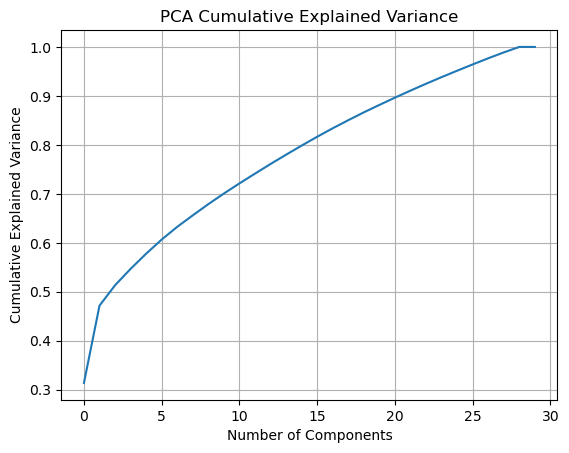

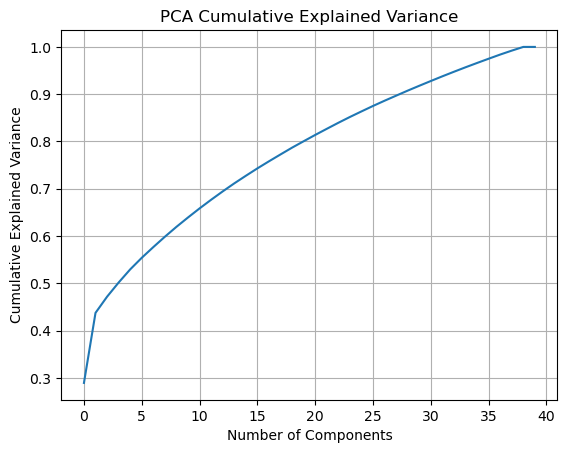

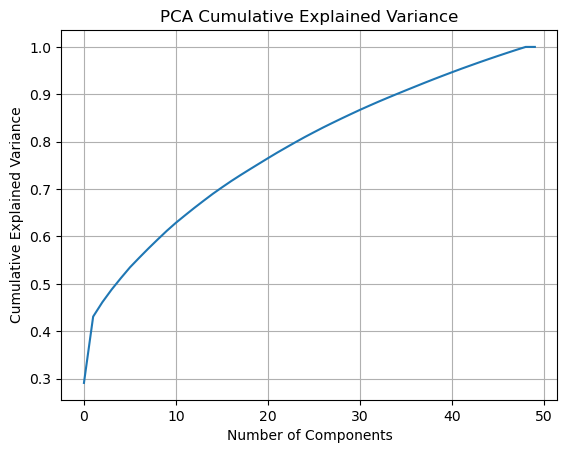

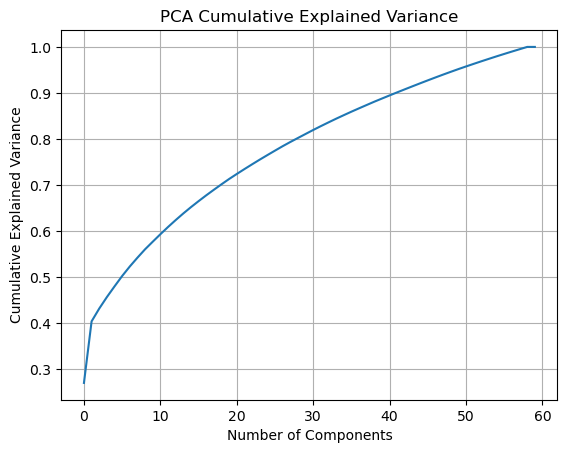

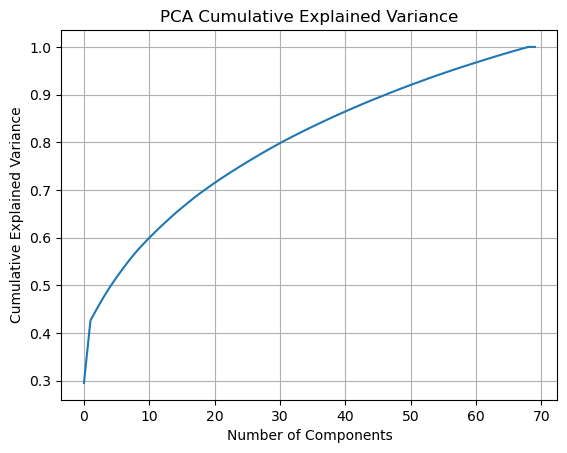

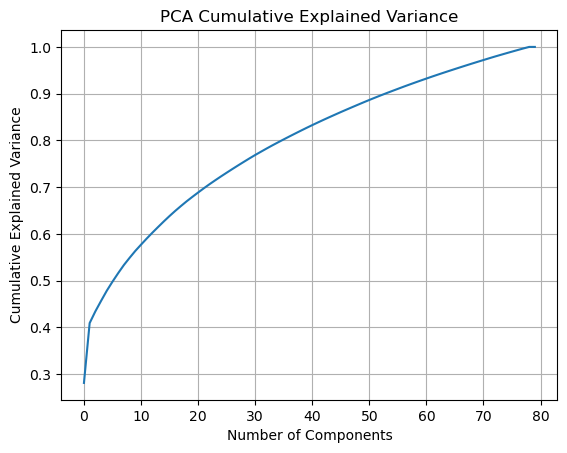

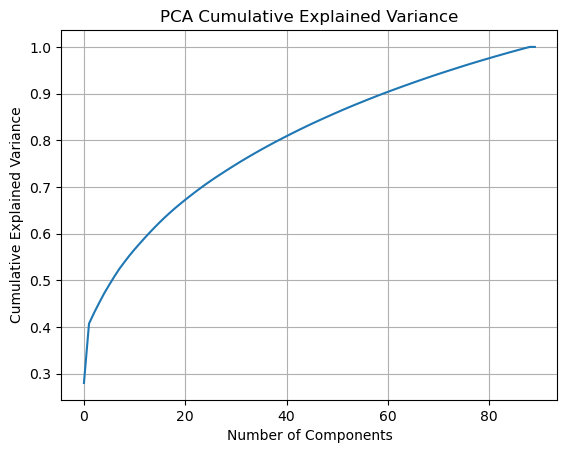

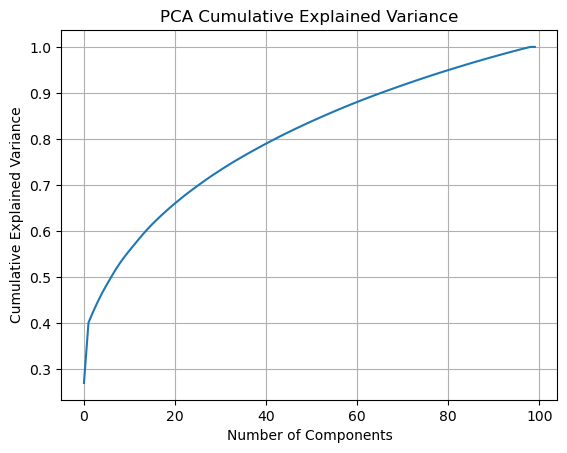

In [272]:
for i in [k*10 for k in range(1, 11)]:
    look_at_curve(i, log_src_cls)

In [260]:
threshold, num_components

(0.95, 82)

In [261]:
mean_ps_pca.shape, components.shape, explained_variance.shape

((6144,), (82, 6144), (82,))

In [262]:
data = np.load("all_ps_100GHz.npz")
mean_ps_pca = data['mean']
components = data['components']
explained_variance = data['variance']

In [263]:
num_components = len(explained_variance)

# Generate random samples in the reduced space
num_samples = 100  # Number of new power spectra you want to generate
# Standard deviation is the square root of the explained variance
std_devs = np.sqrt(explained_variance[:num_components])
reduced_samples = np.random.normal(0, std_devs, (num_samples, num_components))

In [264]:
# Reconstruct power spectra in log10 space
reconstructed_log_ps = reduced_samples @ components[:num_components] + mean_ps_pca

# Convert back to the original space by applying the inverse log10 transformation
reconstructed_ps = 10**reconstructed_log_ps

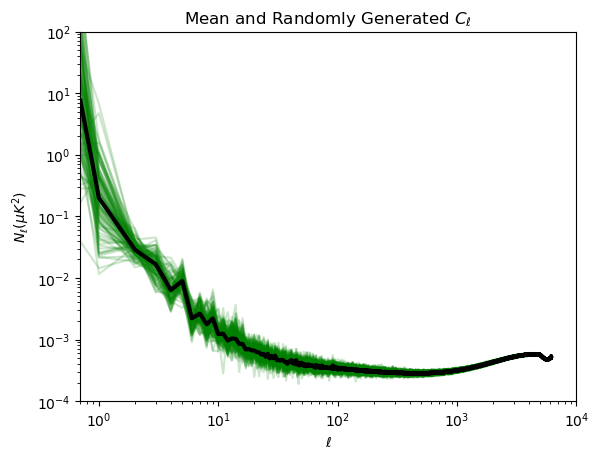

In [265]:
plot_many_ps_hl_last([*reconstructed_ps, 10**mean_ps_pca], title="Mean and Randomly Generated $C_{\\ell}$", legend=False)

100


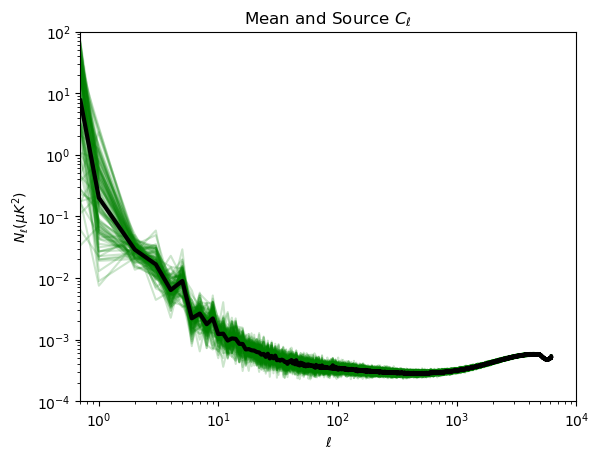

In [266]:
print(len(src_cls))
plot_many_ps_hl_last([*src_cls, 10**mean_ps_pca], title="Mean and Source $C_{\\ell}$", legend=False)

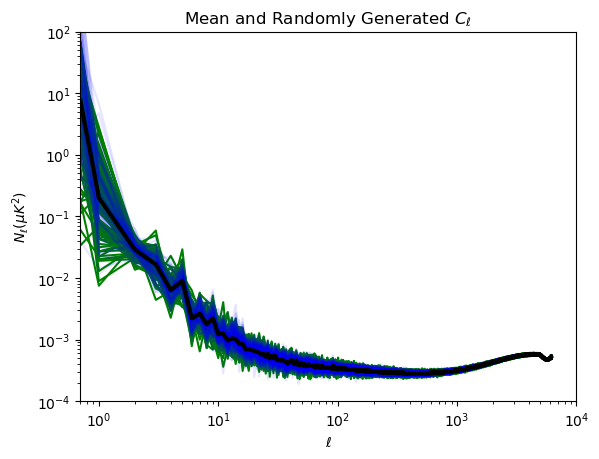

In [267]:
plot_many_ps_hl_last2([*src_cls, *reconstructed_ps, 10**mean_ps_pca], title="Mean and Randomly Generated $C_{\\ell}$", 
                     colors=[*['green']*len(src_cls), *['blue']*len(reconstructed_ps), 'black'], 
                     alphas=[*[1]*len(src_cls), *[0.1]*len(reconstructed_ps), 1], legend=False)

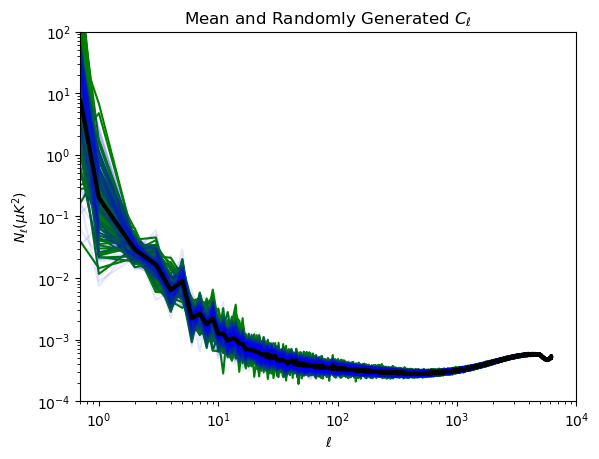

In [268]:
plot_many_ps_hl_last2([*reconstructed_ps, *src_cls, 10**mean_ps_pca], title="Mean and Randomly Generated $C_{\\ell}$", 
                     colors=[*['green']*len(src_cls), *['blue']*len(reconstructed_ps), 'black'], 
                     alphas=[*[1]*len(src_cls), *[0.1]*len(reconstructed_ps), 1], legend=False)

# Justifying using log-scaled Cl's

It's not great justification, but it's the one I've got.

In [342]:
def do_hist(ell_, cls_src, cls_recon, title):
    c_ell_src = np.array([s[ell_] for s in cls_src])
    c_ell_recon = np.array([s[ell_] for s in cls_recon])
    min_val = min(np.min(c_ell_src), np.min(c_ell_recon))
    max_val = max(np.max(c_ell_src), np.max(c_ell_recon))
    bins = np.linspace(min_val, max_val, 20)
    plt.hist(c_ell_src, bins=bins, alpha=0.3, label="Source")
    plt.hist(c_ell_recon, bins=bins, alpha=0.3, label="Reconstructed")
    plt.title(title)
    plt.legend()
    plt.show()

# Look at Regular Scale Cls (not log scale)

In [351]:
def do_hist1(ell_, cls_src, title):
    c_ell_src = np.array([s[ell_] for s in cls_src])
    min_val = np.min(c_ell_src)
    max_val = np.max(c_ell_src)
    bins = np.linspace(min_val, max_val, 20)
    plt.hist(c_ell_src, bins=bins, alpha=0.3, label="Source")
    plt.title(title)
    plt.legend()
    plt.show()

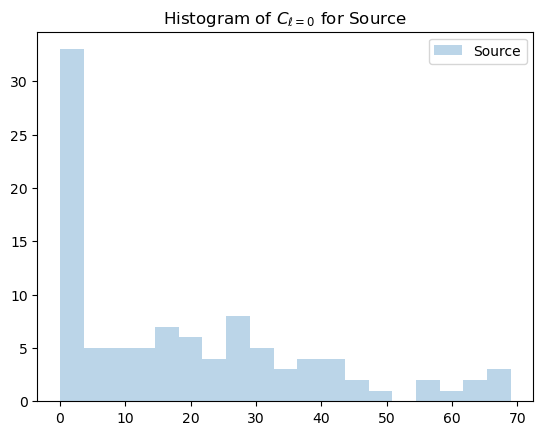

In [352]:
do_hist1(0, src_cls, "Histogram of $C_{\\ell=0}$ for Source")

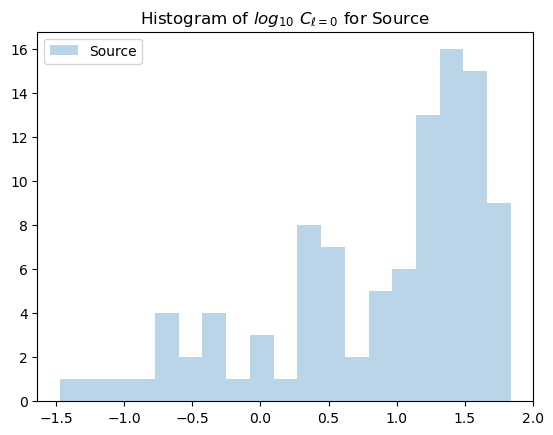

In [356]:
do_hist1(0, [np.log10(s) for s in src_cls], "Histogram of $log_{10}$ $C_{\\ell=0}$ for Source")

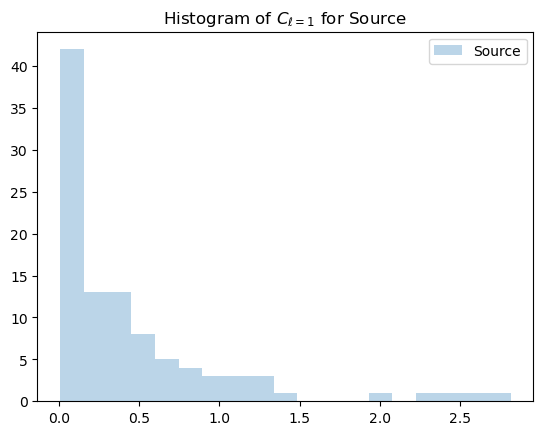

In [354]:
do_hist1(1, src_cls, "Histogram of $C_{\\ell=1}$ for Source")

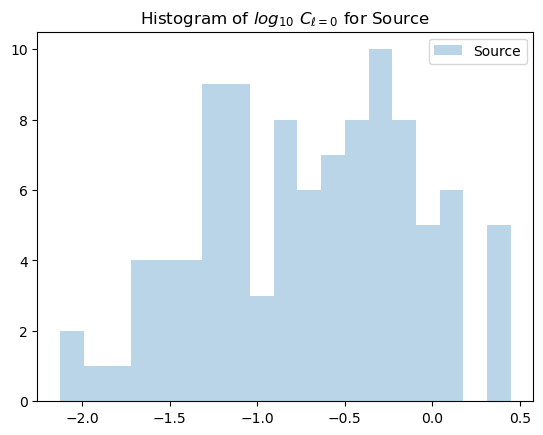

In [357]:
do_hist1(1, [np.log10(s) for s in src_cls], "Histogram of $log_{10}$ $C_{\\ell=0}$ for Source")

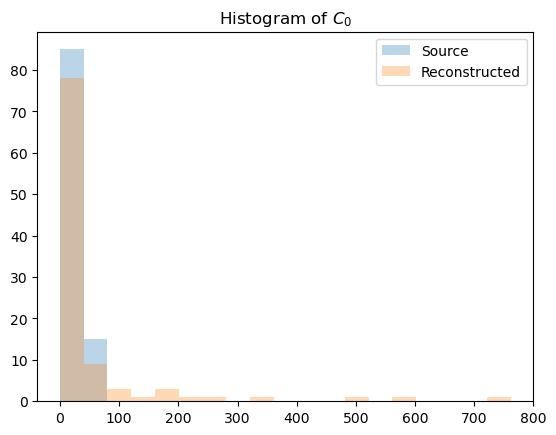

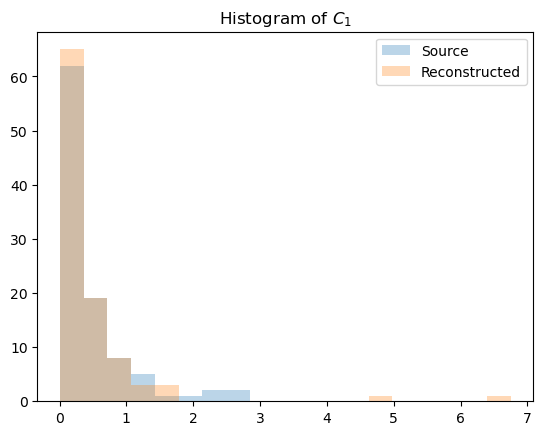

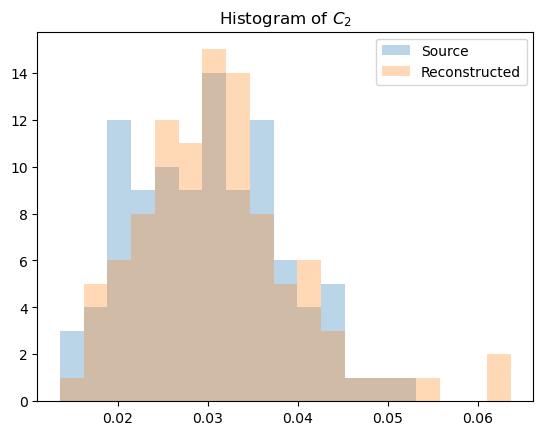

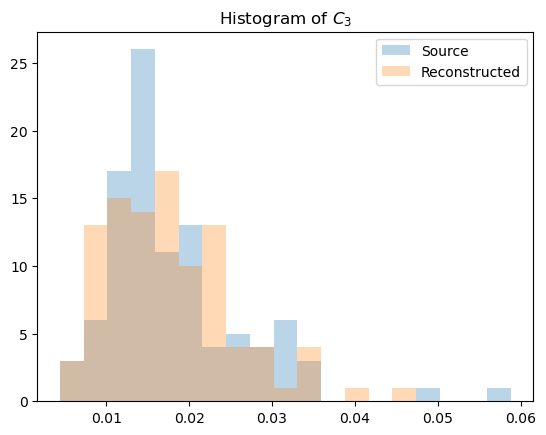

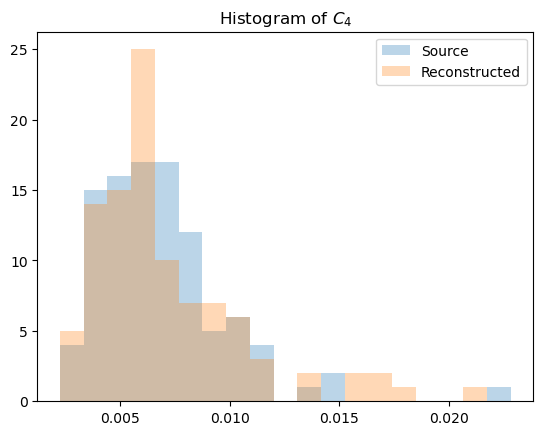

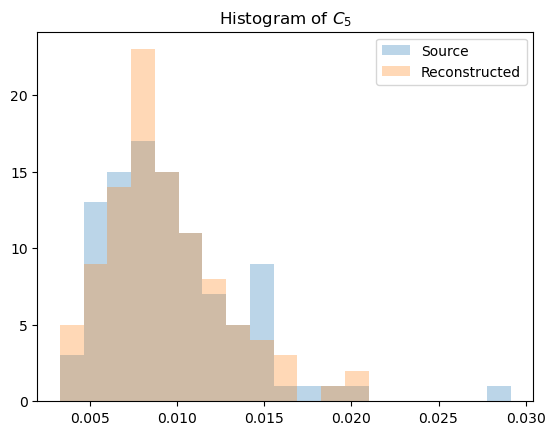

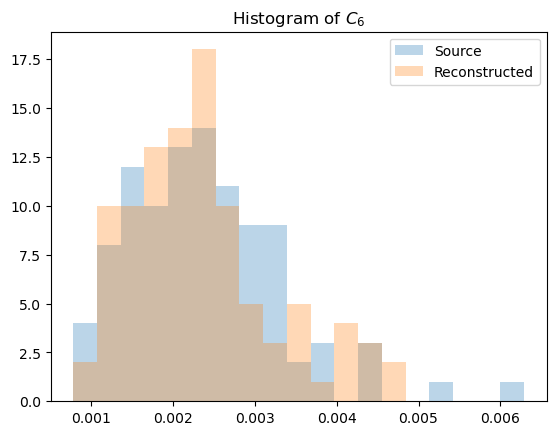

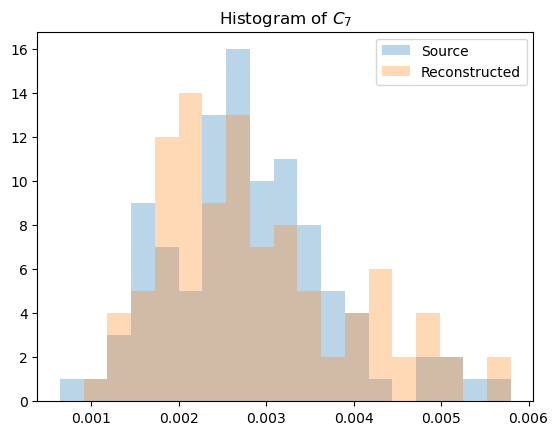

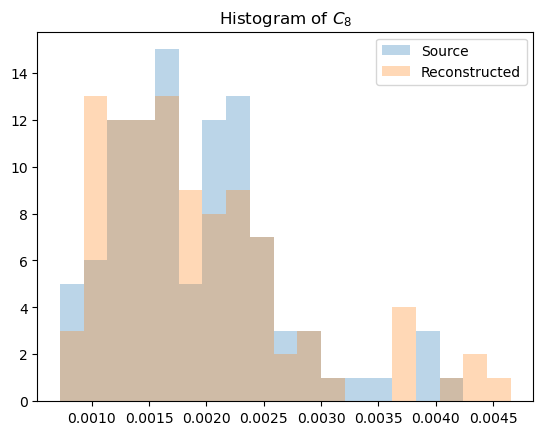

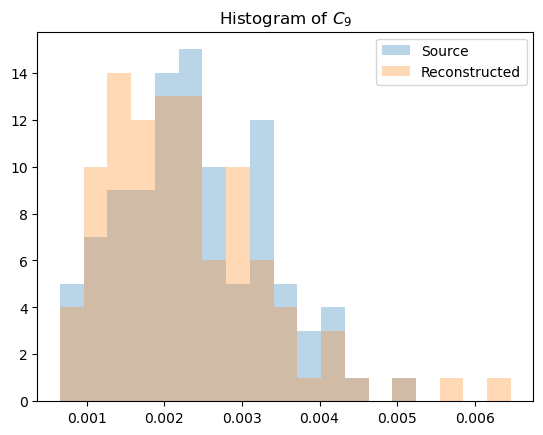

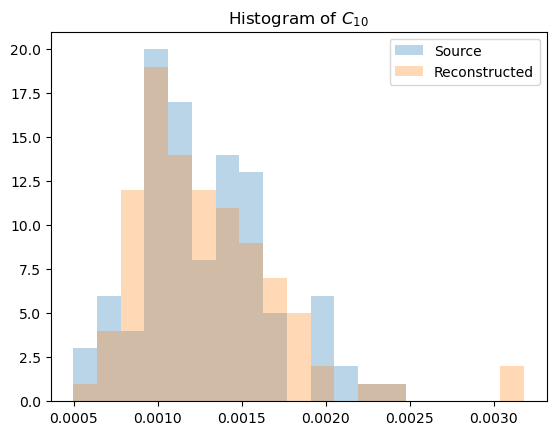

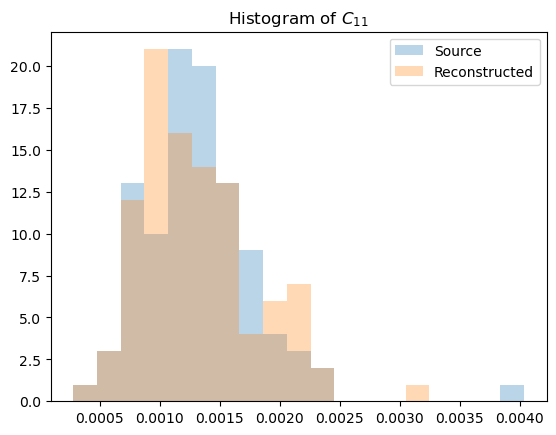

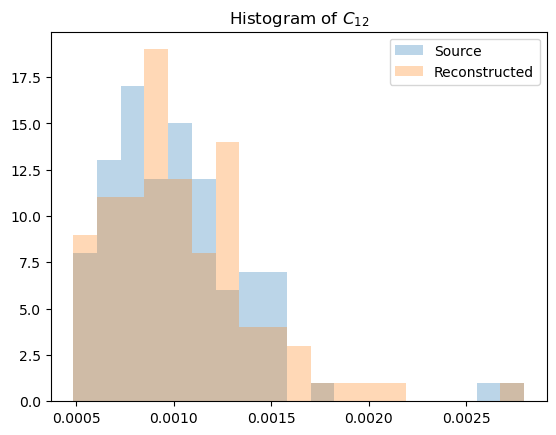

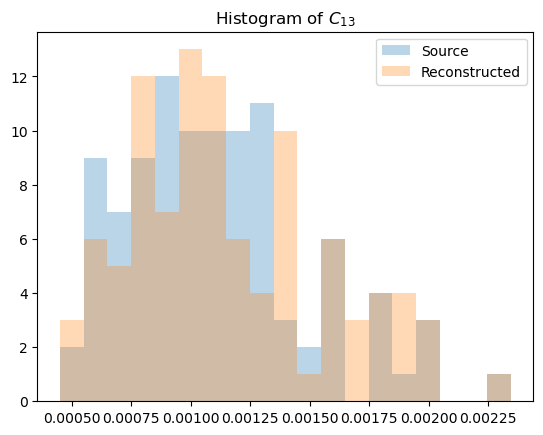

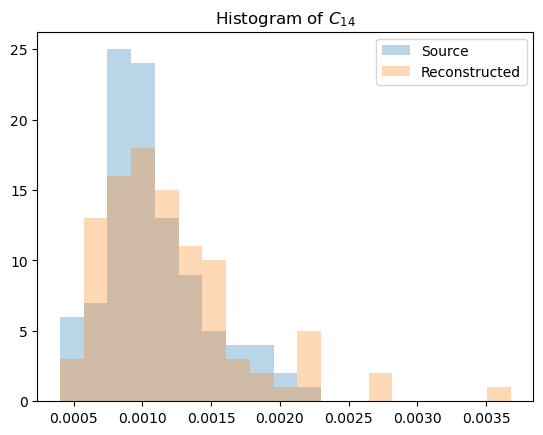

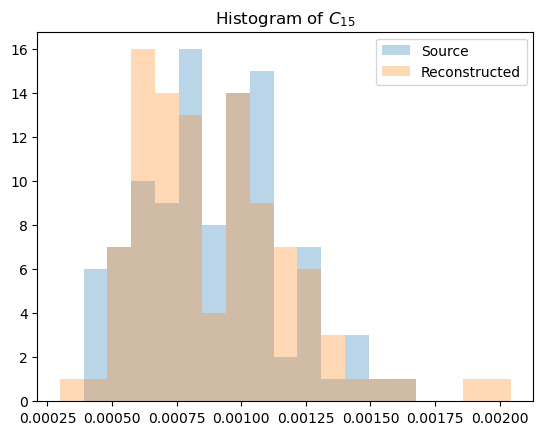

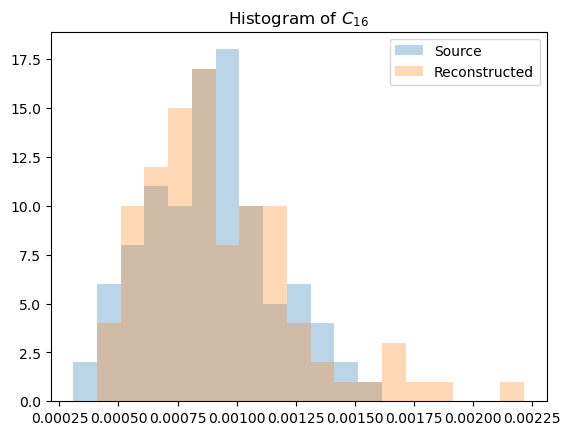

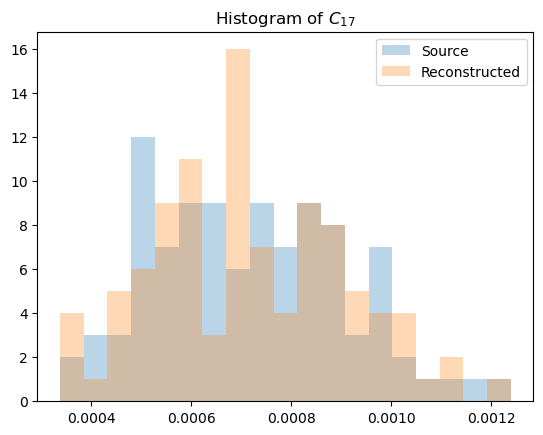

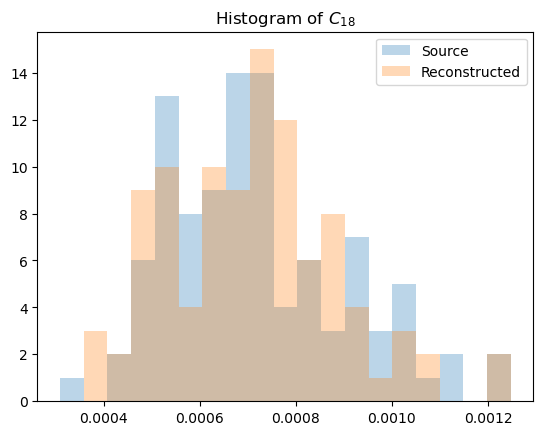

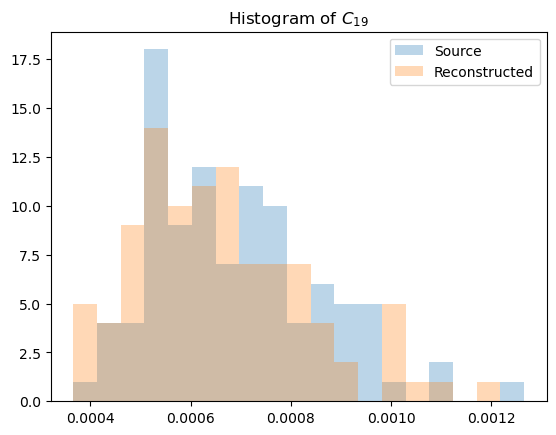

In [345]:
for i in range(20):
    do_hist(i, src_cls, reconstructed_ps, "Histogram of $C_{"+ f"{i}" + "}$")

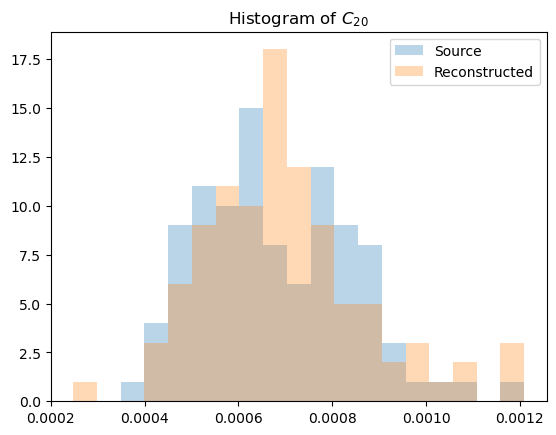

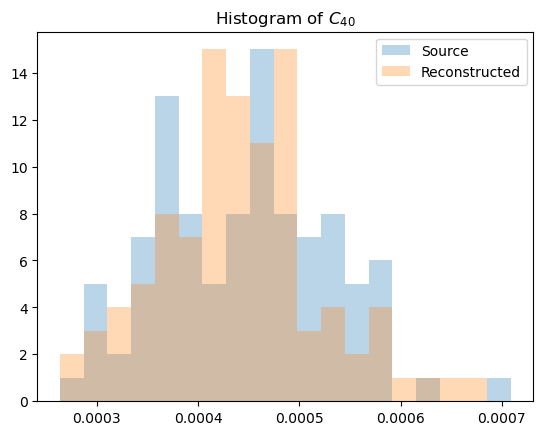

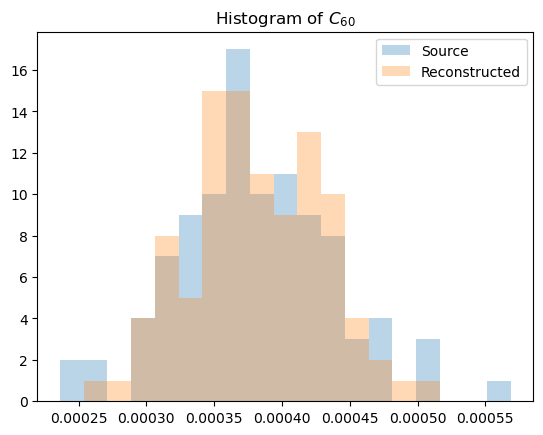

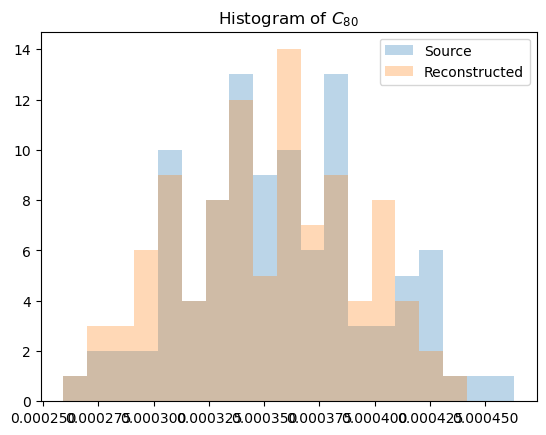

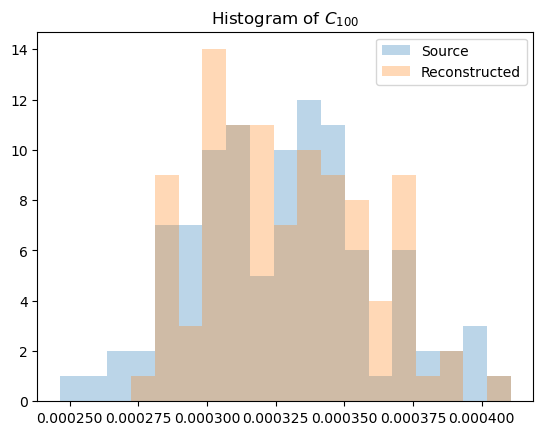

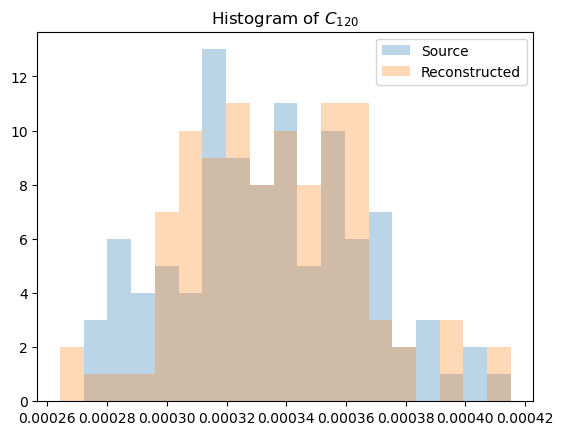

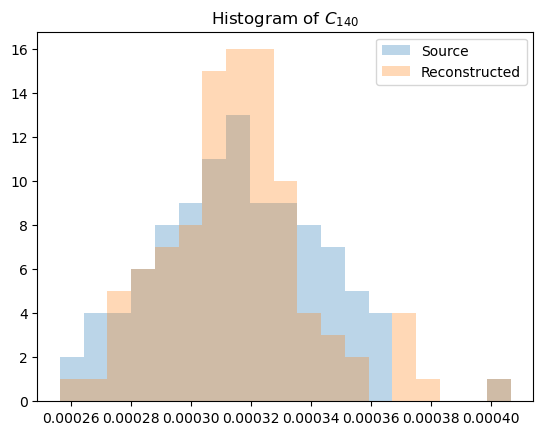

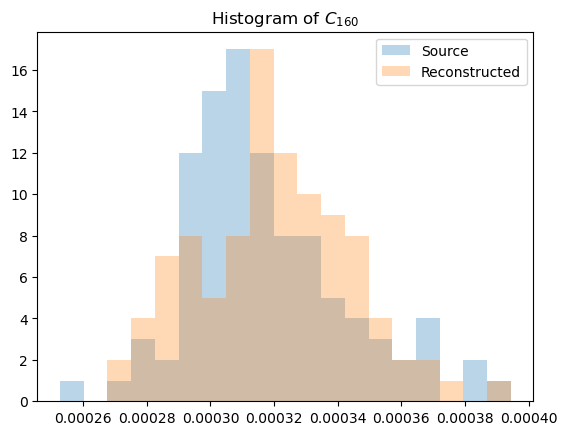

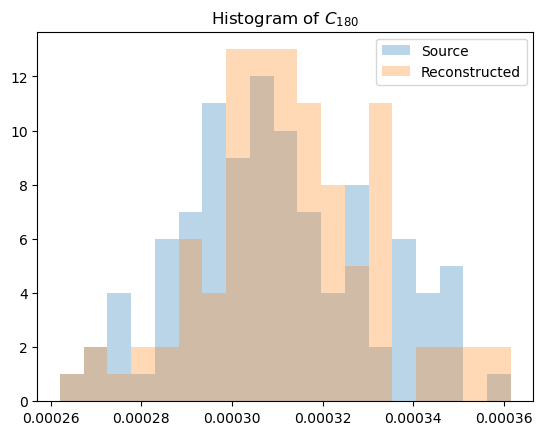

In [346]:
for i in [j*20 for j in range(1, 10)]:
    do_hist(i, src_cls, reconstructed_ps, "Histogram of $C_{"+ f"{i}" + "}$")

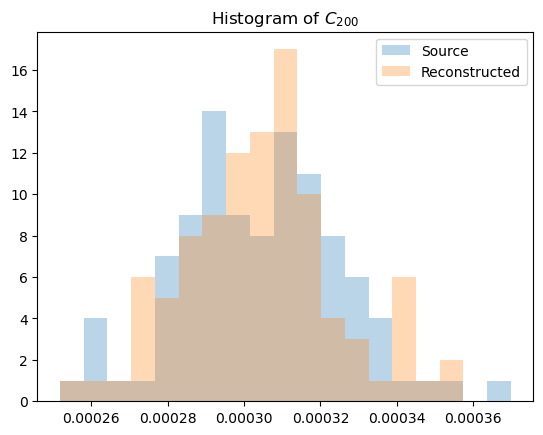

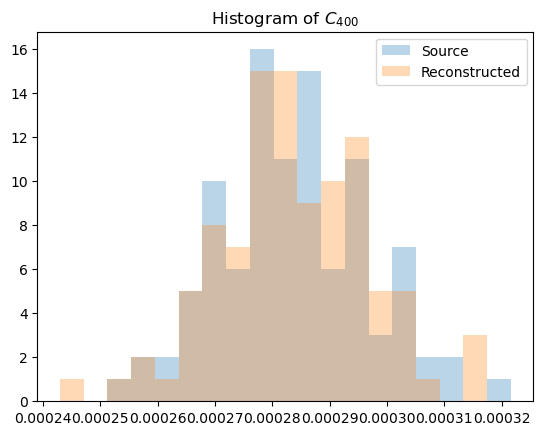

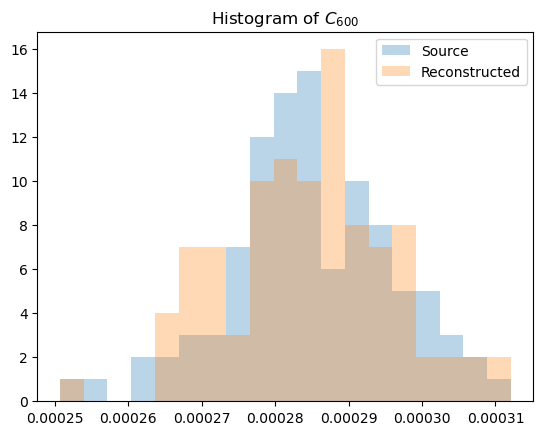

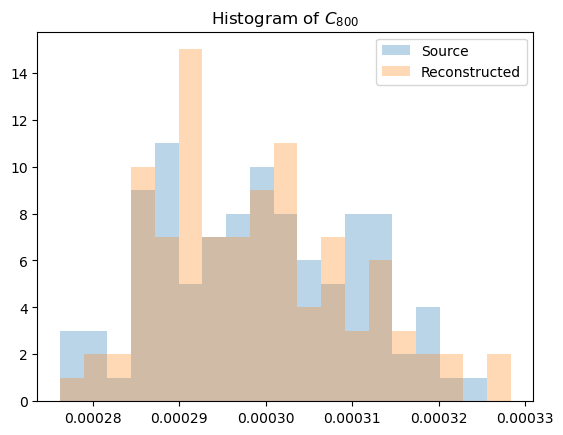

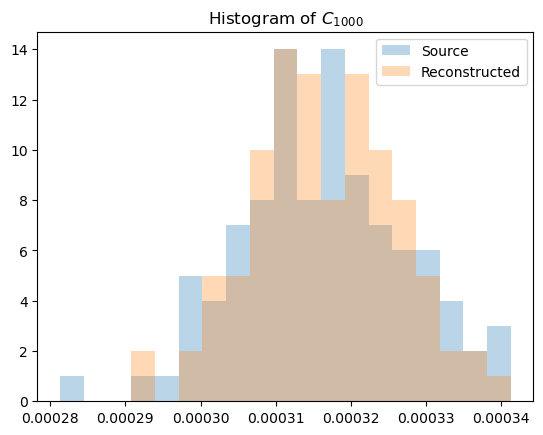

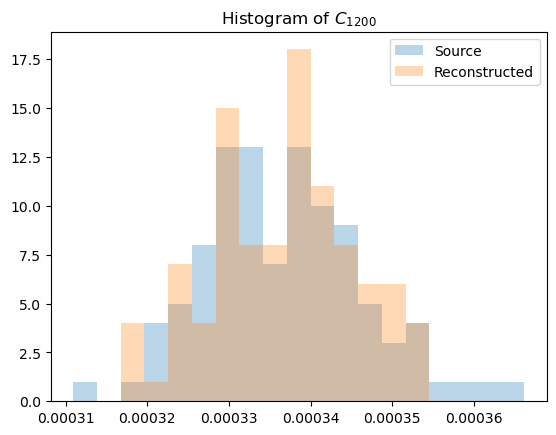

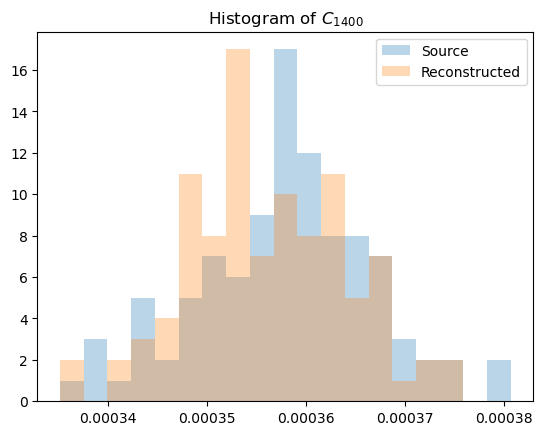

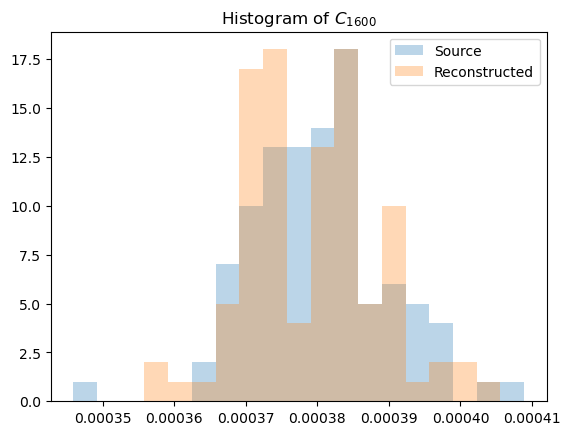

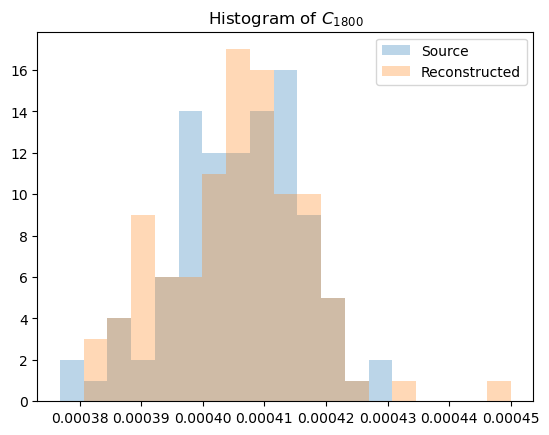

In [347]:
for i in [j*200 for j in range(1, 10)]:
    do_hist(i, src_cls, reconstructed_ps, "Histogram of $C_{"+ f"{i}" + "}$")

# Look at log Scale Cls

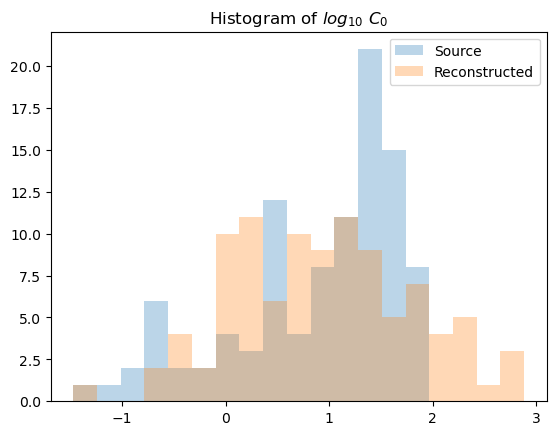

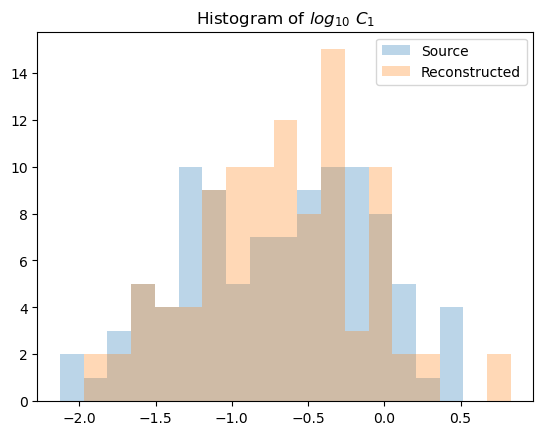

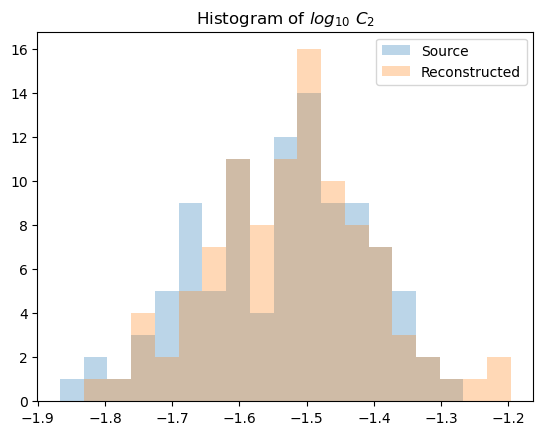

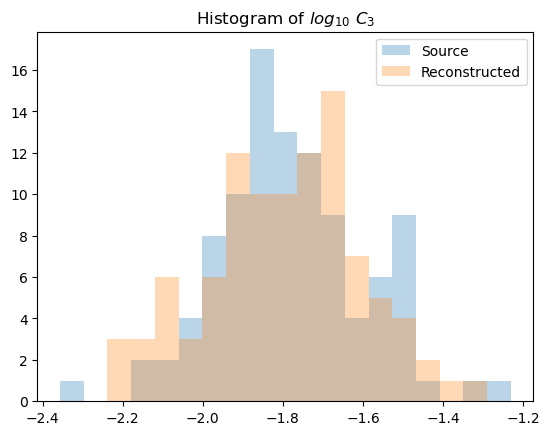

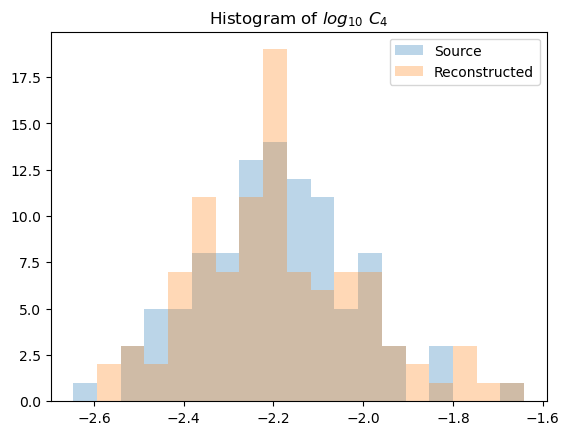

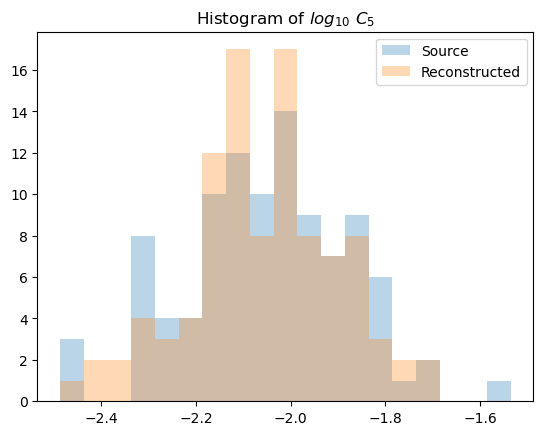

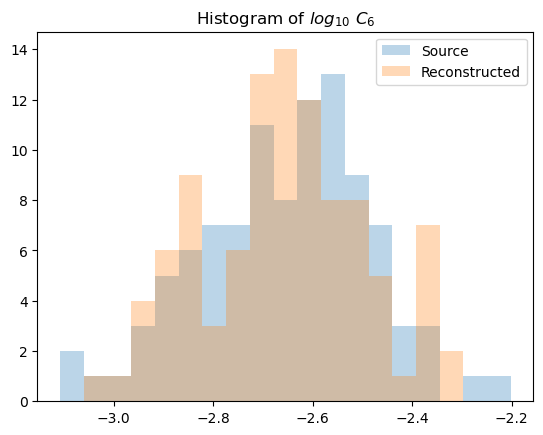

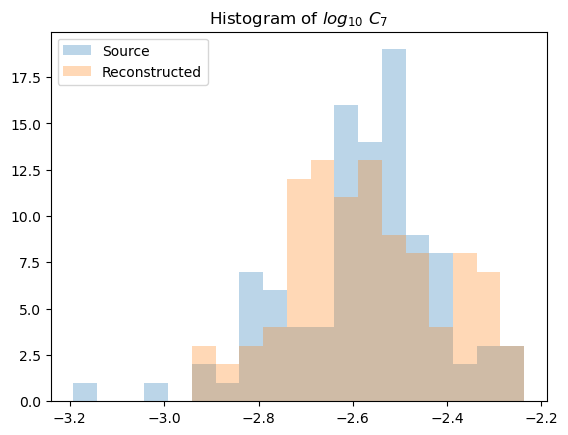

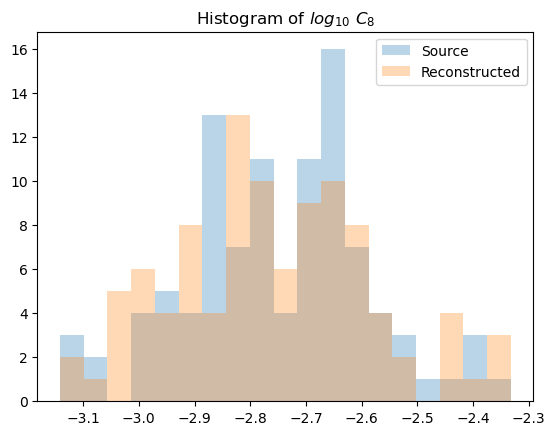

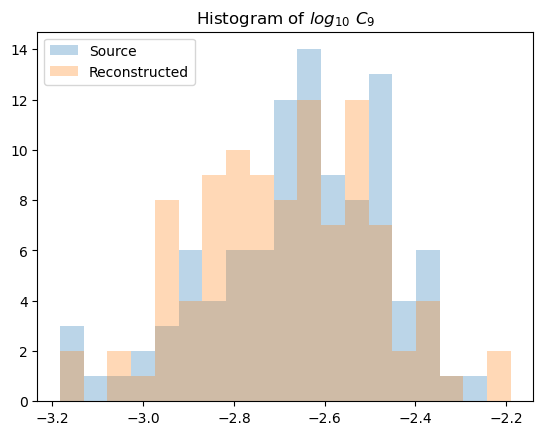

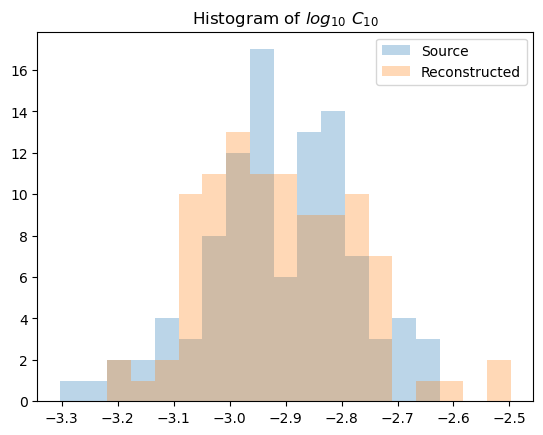

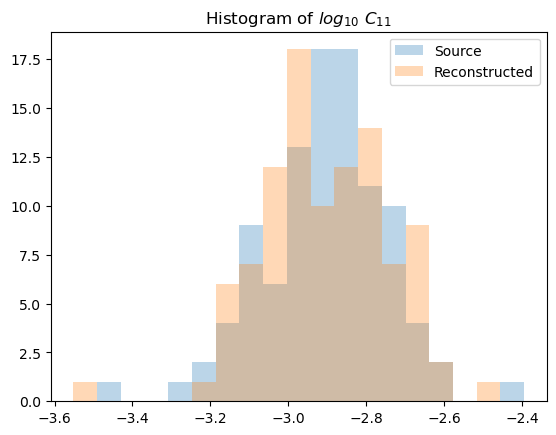

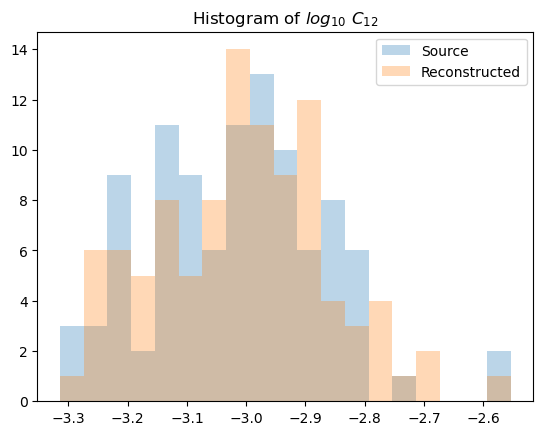

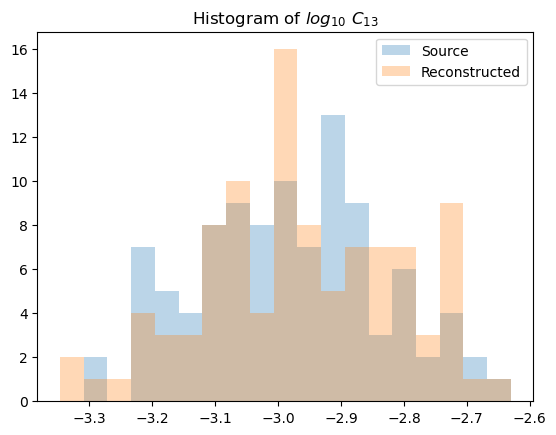

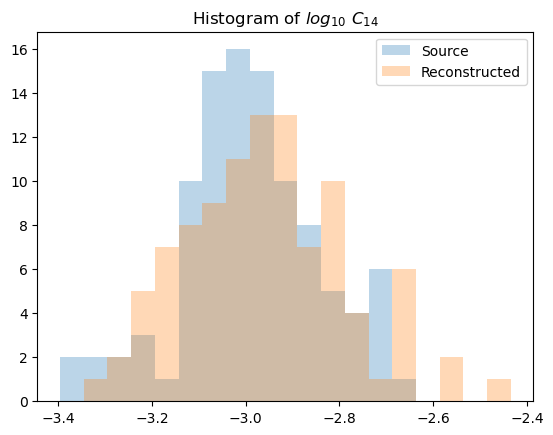

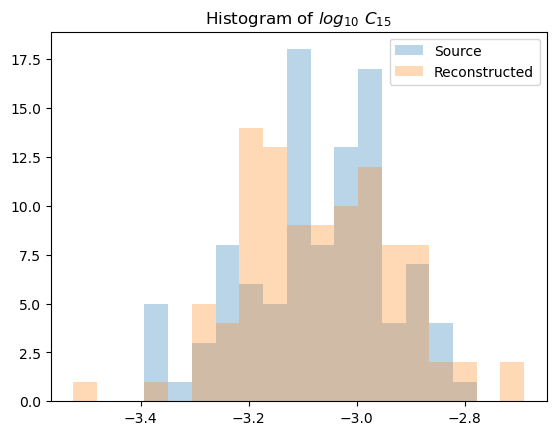

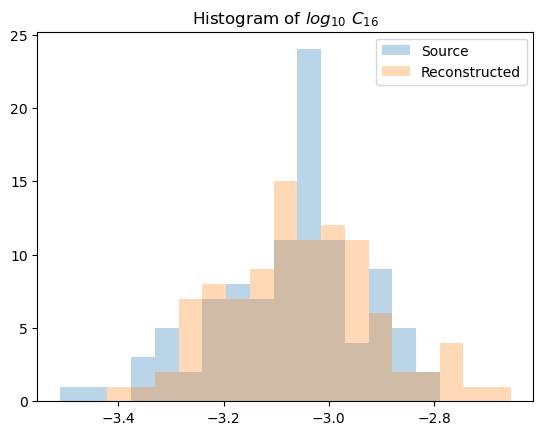

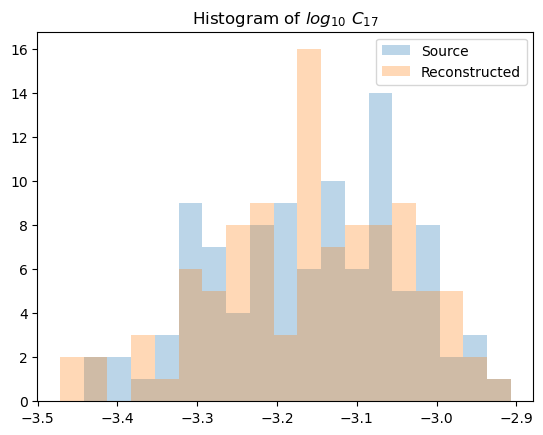

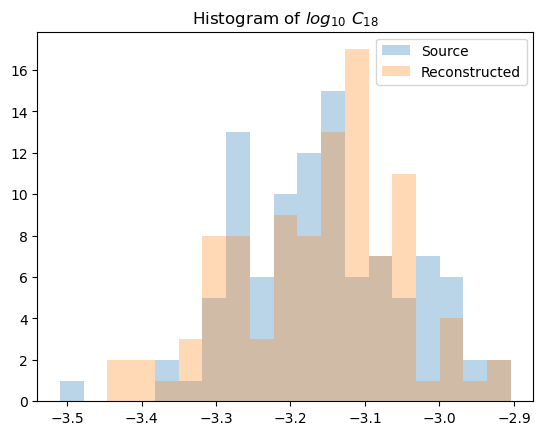

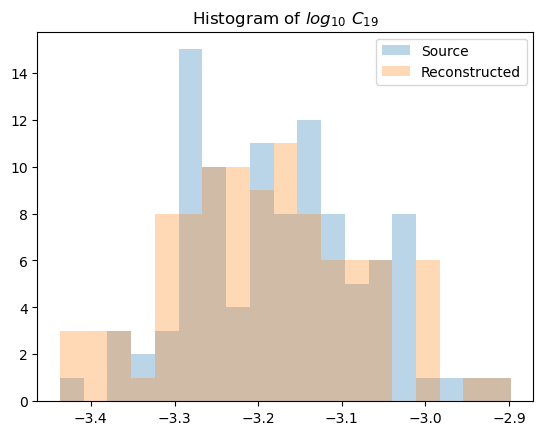

In [349]:
for i in range(20):
    do_hist(i, 
            [np.log10(s) for s in src_cls], 
            [np.log10(t) for t in reconstructed_ps], 
            "Histogram of $log_{10}$ $C_{"+ f"{i}" + "}$")